## Converting the data set to format to be used as an input for a CNN

To convert chess board data into a format that can be used as an input for a CNN, the data is represented as an 8x8x12 binary matrix. Each slice along the third dimension presents the presence of a specific type of piece on the board. 

1. There are 12 possible piece types (6 types for each color: king, queen, rook, bishop, knight, pawn). We can assign each piece an index from 0 to 11. 

- White pieces: pawn, knight, rook, queen, king (0 - 5)
- Black pieces: pawn, knight, rook, queen, king (6 - 11)

2. Board Representation: 

- We will create an 8 x 8 x 12 matrix filled with zeros. 
For each square on the board, if a specific peice is present, set the corresponding position in the matrix to 1. 
- For example, if there's a white knight on e4, we will set the board[4][4][1] = 1 if the white knight has a corresponding index to 1. 


I am following the method used by the following author: https://erikbern.com/2014/11/29/deep-learning-for-chess.html


In [32]:
import numpy as np
import chess
import chess.pgn
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np

In [34]:
spark = SparkSession.builder.appName("ChessGames").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 11:51:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
def board_to_tensor(board):
    
    # Initialize an 8x8x12 tensor of zeros
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    
    # Map piece types to the 3rd dimension indices in the tensor
    piece_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    
    # Iterate over all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)  # Convert square index to 2D coordinates
            color_offset = 0 if piece.color == chess.WHITE else 6  # 0-5 for white, 6-11 for black
            piece_index = piece_to_index[piece.piece_type] + color_offset
            board_tensor[row, col, piece_index] = 1
    
    return board_tensor

In [5]:
board = chess.Board()  # Starting position

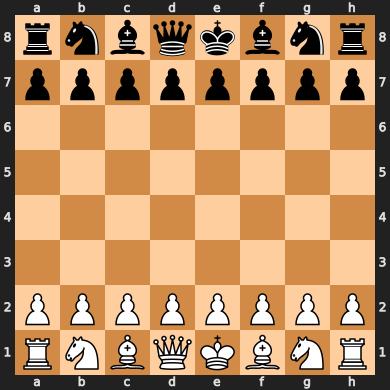

In [9]:
board

In [10]:
tensor = board_to_tensor(board)
tensor

array([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 



### Piece Index Mapping in the Tensor

Each index in the third dimension of the 8 x 8 x 12 tensor represents the presence of a specific piece type on the chessboard. 

The first two dimension (8 x 8): represent the rows and columns of the chessboard. 

The indices are as follows:

| Index | Piece           | Color  |
|-------|------------------|--------|
| 0     | Pawn            | White  |
| 1     | Knight          | White  |
| 2     | Bishop          | White  |
| 3     | Rook            | White  |
| 4     | Queen           | White  |
| 5     | King            | White  |
| 6     | Pawn            | Black  |
| 7     | Knight          | Black  |
| 8     | Bishop          | Black  |
| 9     | Rook            | Black  |
| 10    | Queen           | Black  |
| 11    | King            | Black  |

In this format, a value of `1` at a specific index in the tensor’s third dimension indicates the presence of the respective piece on that square of the chessboard. All other values are `0`, indicating the absence of that piece.

## Our data

In [15]:
file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    # Read the first game in the file
    game = chess.pgn.read_game(pgn_file)
    
    if game:
        # Print headers to confirm access
        print("First game headers:")
        for header, value in game.headers.items():
            print(f"{header}: {value}")
        
        # Initialize a board to track positions
        board = game.board()
        
        print("\nFirst game moves (LAN):")
        for i, move in enumerate(game.mainline_moves()):
            # Apply the move to the board
            board.push(move)
            # Print the move in LAN format
            print(move.uci(), end=" ")
            if i >= 10:  # Limit to the first 10 moves for brevity
                break
        print("\n...")

    else:
        print("No games found in the file or file is not accessible.")

First game headers:
Event: Rated Bullet game
Site: https://lichess.org/nQ1xYNSF
Date: 2024.08.01
Round: -
White: kingskreamer
Black: mysteryvabs
Result: 1-0
UTCDate: 2024.08.01
UTCTime: 00:00:09
WhiteElo: 2148
BlackElo: 2155
WhiteRatingDiff: +6
BlackRatingDiff: -6
ECO: B10
Opening: Caro-Kann Defense: Accelerated Panov Attack
TimeControl: 60+0
Termination: Time forfeit

First game moves (LAN):
e2e4 c7c6 c2c4 d7d5 c4d5 c6d5 e4d5 d8d5 b1c3 d5d8 f1c4 
...


To convert our games to a 8x8x12 matrix:
1. Initialize a starting board position
2. Apply each move to the board
3. After each move, convert the current board position into an 8 x 8 x 12 matrix

In [17]:
def board_to_tensor(board):
    
    # Initialize an 8x8x12 tensor of zeros
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    
    # Map piece types to the 3rd dimension indices in the tensor
    piece_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    
    # Iterate over all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)  # converting teh square index to 2D coordinates
            color_offset = 0 if piece.color == chess.WHITE else 6  # 0-5 for white, 6-11 for black
            piece_index = piece_to_index[piece.piece_type] + color_offset
            board_tensor[row, col, piece_index] = 1
    
    return board_tensor

In [18]:
games_data = []

# Read and process each game in the PGN file
with open(file_path, 'r', encoding='utf-8') as pgn_file:
    while True:
        # Read the next game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break  # End of file

        # List to hold the matrix for each move in the game
        game_matrices = []

        # Initialize the board for the game and apply moves
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            # Convert the board to an 8x8x12 tensor and add to the game_matrices
            game_matrices.append(board_to_tensor(board))

        # Add the entire game (sequence of board positions) to the games_data list
        games_data.append(np.array(game_matrices))

In [20]:
# Checking if games_data has been populated

if games_data:
    # Get the first game
    first_game = games_data[0]
    
    # Display the first few moves (matrices) in the first game
    num_moves_to_show = 5  # Adjust this to see more or fewer moves
    for i in range(min(num_moves_to_show, len(first_game))):
        print(f"Move {i+1}:\n", first_game[i])
else:
    print("games_data is empty. Please check if data was loaded correctly.")

Move 1:
 [[[0 0 0 1 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [

In [25]:
# Prepare data for numpy DataFrame 
data_rows = []
game_id = 0

for game in games_data:
    move_number = 0
    for board_tensor in game:
        # Flatten the board tensor to a 1D array
        flattened_board = board_tensor.flatten()
        data_rows.append({
            'game_id': game_id,
            'move_number': move_number,
            'board_state': flattened_board.tolist()  # Convert to list for DataFrame compatibility
        })
        move_number += 1
    game_id += 1

In [26]:
df = pd.DataFrame(data_rows)


In [27]:
print(df.head())
# board_state is a flattened array of 768 values, representing an 8 x 8 x 12 board.

   game_id  move_number                                        board_state
0        0            0  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1        0            1  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
2        0            2  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
3        0            3  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4        0            4  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...


### Why saving as parquet file?
I am saving this as a parquet file as it will store the data more efficiently and is comitable for distributed systems like Spark

In [37]:
# Prepare data for Spark DataFrame
flattened_games_data = []
for game_index, game in enumerate(games_data):
    for move_index, board_state in enumerate(game):
        # Flatten the board_state to store it as a single row in a DataFrame
        flattened_state = board_state.flatten().tolist()
        flattened_games_data.append(Row(game_id=game_index, move_id=move_index, board_state=flattened_state))

# Create DataFrame
df = spark.createDataFrame(flattened_games_data)

In [38]:
df.show(5)


24/11/04 12:01:41 WARN TaskSetManager: Stage 0 contains a task of very large size (100198 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------+--------------------+
|game_id|move_id|         board_state|
+-------+-------+--------------------+
|      0|      0|[0, 0, 0, 1, 0, 0...|
|      0|      1|[0, 0, 0, 1, 0, 0...|
|      0|      2|[0, 0, 0, 1, 0, 0...|
|      0|      3|[0, 0, 0, 1, 0, 0...|
|      0|      4|[0, 0, 0, 1, 0, 0...|
+-------+-------+--------------------+
only showing top 5 rows



24/11/04 12:01:47 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


In [39]:
df.printSchema()


root
 |-- game_id: long (nullable = true)
 |-- move_id: long (nullable = true)
 |-- board_state: array (nullable = true)
 |    |-- element: long (containsNull = true)



In [41]:
df.count()

24/11/04 12:03:05 WARN TaskSetManager: Stage 2 contains a task of very large size (100198 KiB). The maximum recommended task size is 1000 KiB.


66320

In [40]:
parquet_file_path = '/scratch/zrc3hc/converted_games_data.parquet'
df.write.parquet(parquet_file_path, mode="overwrite")
print(f"Saved games_data to {parquet_file_path} as a Parquet file")


24/11/04 12:02:30 WARN TaskSetManager: Stage 1 contains a task of very large size (100198 KiB). The maximum recommended task size is 1000 KiB.


Saved games_data to /scratch/zrc3hc/converted_games_data.parquet as a Parquet file


### Saving Additional Game Information

Below is code for saving extra details that may be relevant later for the cnn. This will be saved as a CSV. 

In [46]:
file_path = '/scratch/zrc3hc/filtered_bullet_games_first_1000.pgn'
output_csv_path = '/scratch/zrc3hc/filtered_games_summary.csv'

In [42]:
games_info_list = []
game_id = 0

with open(file_path, 'r', encoding='utf-8') as pgn_file:
    while True:
        # Read the next game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break  # End of file
        
        # Extract the required header information and store it as a dictionary
        game_info = {
            'game_id': game_id,
            'WhiteElo': game.headers.get('WhiteElo', ''),
            'BlackElo': game.headers.get('BlackElo', ''),
            'WhiteRatingDiff': game.headers.get('WhiteRatingDiff', ''),
            'BlackRatingDiff': game.headers.get('BlackRatingDiff', ''),
            'Result': game.headers.get('Result', '')
        }
        
        # Append the dictionary to the list
        games_info_list.append(game_info)
        
        # Increment the game_id for the next game
        game_id += 1

In [44]:
df_info = pd.DataFrame(games_info_list)
print(df_info.head())

   game_id WhiteElo BlackElo WhiteRatingDiff BlackRatingDiff Result
0        0     2148     2155              +6              -6    1-0
1        1     1103     1106              +5              -6    1-0
2        2      674      629              -7              +7    0-1
3        3     2459     2556              -4              +5    0-1
4        4     1527     1500              -6              +6    0-1


In [47]:
df_info.to_csv(output_csv_path, index=False)
print(f"Saved game details to {output_csv_path}")

Saved game details to /scratch/zrc3hc/filtered_games_summary.csv
